In [3]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
style.use('plotting.mplstyle')
import numpy as np
import json
from scipy.stats import gaussian_kde
import sys

sys.path.append('./../code/emceeCode')
from posterior_helper_functions import *

First, generate all the data to plot

In [8]:
# Define function to draw n chi-effective values corresponding to a component spin + mass ratio 
# distribution w/ parameters {mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, cost_min, Bq}

def drawChieffs(mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, cost_min, Bq, n=1): 
    
    # transform from mu and sigma to a and b for beta distribution
    a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
    
    # draw uniform component spins + masses
    nRandomDraws = 10000
    samp_idxs = np.arange(nRandomDraws)
    chi1s = np.random.rand(nRandomDraws)
    chi2s = np.random.rand(nRandomDraws)
    cost1s = np.random.rand(nRandomDraws)*2 - 1
    cost2s = np.random.rand(nRandomDraws)*2 - 1
    mAs = np.random.rand(nRandomDraws)*100
    mBs = np.random.rand(nRandomDraws)*100
    m1s = np.maximum(mAs, mBs)
    m2s = np.minimum(mAs, mBs)
    
    
    # calculate p(spins,masses) for these uniform samples,
    # using functions from posterior_helper_functions.py
    if f_spike is None: 
        p_chi1 = betaDistribution(chi1s, a, b)
        p_chi2 = betaDistribution(chi2s, a, b)
    else: 
        p_chi1 = betaDistributionPlusSpike(chi1s, a, b, f_spike, sigma_spike)
        p_chi2 = betaDistributionPlusSpike(chi2s, a, b, f_spike, sigma_spike)
    p_cost1 = calculate_Gaussian_Mixture_1D(cost1s, 1, sigma_cost, MF_cost, cost_min, 1)
    p_cost2 = calculate_Gaussian_Mixture_1D(cost2s, 1, sigma_cost, MF_cost, cost_min, 1)
    p_masses = p_astro_masses(m1s, m2s, bq=Bq)
    
    weights = p_chi1*p_chi2*p_cost1*p_cost2*p_masses
    weights_normed = weights/np.sum(weights)
    weights_normed[np.where(weights_normed<0)] = 0 # get rid of tiny division errors
    
    # select a subset of the samples subject to the weights
    # calculated from p(spins,masses)
    idxs = np.random.choice(samp_idxs, p=weights_normed, size=n)  
    
    # calculate chi-eff for these samples
    q = m2s[idxs]/m1s[idxs]
    chi_eff = (chi1s[idxs]*cost1s[idxs] + q*chi2s[idxs]*cost2s[idxs])/(1+q)
    
    return chi_eff

In [5]:
# Load data
root = '../data'
models = ['betaPlusMixture', 'betaPlusTruncatedMixture', 'betaSpikePlusMixture', 'betaSpikePlusTruncatedMixture']

data_dict = {}
for model in models: 
    with open(f'{root}/component_spin_{model}.json', 'r') as f:
        data = json.load(f)
    data_dict[model]= {key:data[key]['processed'] for key in data.keys()}

In [20]:
# Set up dictionary with plotting data, to eventually save such that we do not have to repeat these steps 
plotting_dict = {}

for model in models: 
    plotting_dict[model] = {}

In [21]:
# Grids on which to evaluate dists
chi_grid = np.linspace(0,1,500)
cost_grid = np.linspace(-1,1,500)
chieff_grid = np.linspace(-1,1,500)

In [24]:
# Generate traces corresponding to each model

n_Traces = 500

for model in models: 
        
    print(f'Calculating traces for {model}...')
    
    data = data_dict[model]
    idxs = np.random.choice(np.arange(len(data['mu_chi'])), size=n_Traces, replace=False)
        
    # initialize arrays 
    chis_on_grid = np.zeros((n_Traces, chi_grid.size))
    costs_on_grid = np.zeros((n_Traces, cost_grid.size))
    chieff_kdes_on_grid = np.zeros((n_Traces, chieff_grid.size))
    
    # cycle through downsampled hyper parameters  
    for n,i in enumerate(idxs): 
        
        mu_chi = data_dict[model]['mu_chi'][i]
        sigma_chi = data_dict[model]['sigma_chi'][i]                                
        MF_cost = data_dict[model]['MF_cost'][i]
        sigma_cost = data_dict[model]['sigma_cost'][i]
        Bq = data_dict[model]['Bq'][i]
        
        a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
        
        # specific distribution we calculate depends on the model of interest
        if model=='betaPlusMixture': 
            f_spike = None
            sigma_spike = None
            zmin = -1
            # calculate chis 
            chis_on_grid[n,:] = betaDistribution(chi_grid, a, b)     
            # calculate costs 
            costs_on_grid[n,:] = calculate_Gaussian_Mixture_1D(cost_grid, 1, sigma_cost, MF_cost, zmin, 1)    

        elif model=='betaPlusTruncatedMixture': 
            f_spike = None
            sigma_spike = None
            zmin = data_dict[model]['cost_min'][i]
            # calculate chis 
            chis_on_grid[n,:] = betaDistribution(chi_grid, a, b)     
            # calculate costs 
            costs_on_grid[n,:] = calculate_Gaussian_Mixture_1D(cost_grid, 1, sigma_cost, MF_cost, zmin, 1)

        elif model=='betaSpikePlusMixture': 
            f_spike = data_dict[model]['frac_in_spike'][i]
            sigma_spike = data_dict[model]['sigma_spike'][i]
            zmin = -1
             # calculate chis 
            chis_on_grid[n,:] = betaDistributionPlusSpike(chi_grid, a, b, f_spike, sigma_spike)     
            # calculate costs 
            costs_on_grid[n,:] = calculate_Gaussian_Mixture_1D(cost_grid, 1, sigma_cost, MF_cost, zmin, 1)

        elif model=='betaSpikePlusTruncatedMixture':
            f_spike = data_dict[model]['frac_in_spike'][i]
            sigma_spike = data_dict[model]['sigma_spike'][i]
            zmin = data_dict[model]['cost_min'][i]
            # calculate chis 
            chis_on_grid[n,:] = betaDistributionPlusSpike(chi_grid, a, b, f_spike, sigma_spike)     
            # calculate costs 
            costs_on_grid[n,:] = calculate_Gaussian_Mixture_1D(cost_grid, 1, sigma_cost, MF_cost, zmin, 1)
        
        else: 
            print('model not found, something wrong')
            break    
        
        # draw chi-effectives from this distribution
        chi_effs = drawChieffs(mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq, n=500)
        
        # calculate KDE from these draws
        chieff_kde = gaussian_kde(chi_effs)
        chieff_kdes_on_grid[n,:] = chieff_kde(chieff_grid)
        
    # add results to master dict
    plotting_dict[model]['chi_on_grid'] = chis_on_grid
    plotting_dict[model]['cost_on_grid'] = costs_on_grid
    plotting_dict[model]['chi_eff_on_grid'] = chieff_kdes_on_grid

Calculating traces for betaPlusMixture...


/home/simona.miller/gwtc3-spin-studies/figures/./../code/emceeCode/posterior_helper_functions.py:257: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


Calculating traces for betaPlusTruncatedMixture...
Calculating traces for betaSpikePlusMixture...
Calculating traces for betaSpikePlusTruncatedMixture...


In [18]:
# For comparison, look at double gaussian chi-eff results 

data_doubleGaussian = az.from_netcdf("../data/effective_spin_doubleGaussians.cdf")
stacked_samples_doubleGaussian = data_doubleGaussian.posterior.stack(draws=("chain", "draw"))

nSamps = 1000
pdf_doubleGaussian = np.zeros((nSamps,chieff_grid.size))

# Loop across a random set of posterior samples
samples_to_plot = np.random.choice(np.arange(stacked_samples_doubleGaussian.mu_chi_high.size),nSamps,replace=False)
for i,sample in enumerate(samples_to_plot):
    
    # Read out hyperparameters
    mu_chi_high = stacked_samples_doubleGaussian.mu_chi_high.values[sample]
    mu_chi_low = stacked_samples_doubleGaussian.mu_chi_low.values[sample]
    logsig_chi_high = stacked_samples_doubleGaussian.logsig_chi_high.values[sample]
    logsig_chi_low = stacked_samples_doubleGaussian.logsig_chi_low.values[sample]
    zeta_high = stacked_samples_doubleGaussian.zeta_high.values[sample]
    
    # Compute and store PDF
    pdf_doubleGaussian[i,:] = (1.-zeta_high)*calculate_Gaussian_1D(chieff_grid,mu_chi_low,10.**logsig_chi_low,-1,1) + zeta_high*calculate_Gaussian_1D(chieff_grid,mu_chi_high,10.**logsig_chi_high,-1,1)
    
doublegaussian_chieff_PPD = np.mean(pdf_doubleGaussian, axis=0)

Then plot the data

In [19]:
# some macros for plotting
labels = [r'\texttt{Beta + Mixture}', r'\texttt{Beta + TruncatedMixture}', r'\texttt{BetaSpike + Mixture}', r'\texttt{BetaSpike + TruncatedMixture}']
colors = [(51/256,160/256,44/256), (51/256,160/256,44/256), (227/256,26/256,28/256), (227/256,26/256,28/256)]
alpha=0.03

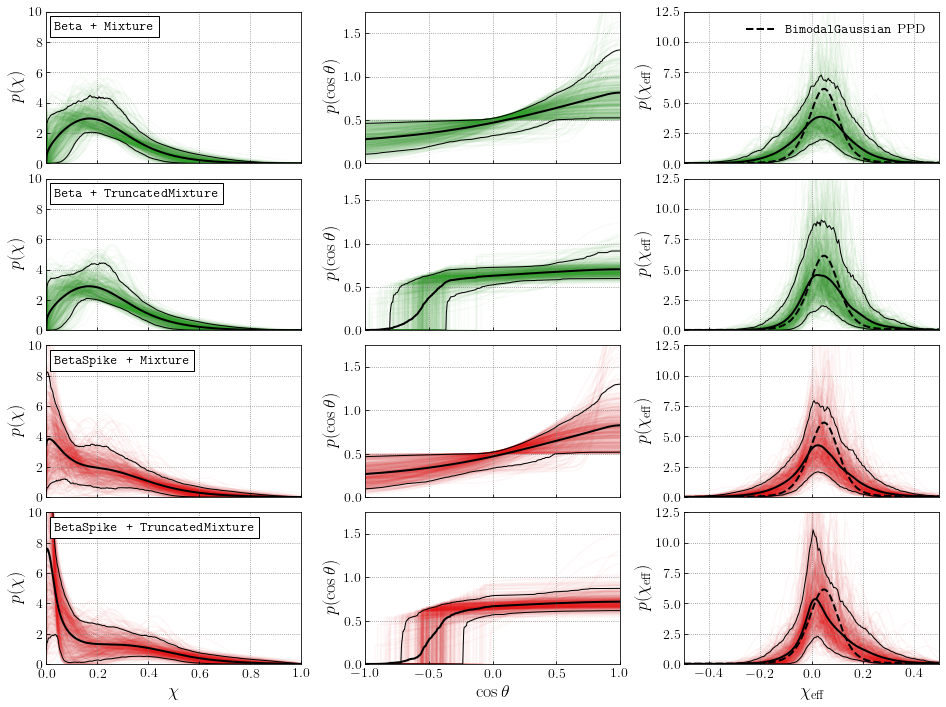

<Figure size 432x324 with 0 Axes>

In [27]:
# make figure
fig, axes = plt.subplots(4,3, figsize=(16,12))

for ax,model,label,color in zip(axes,models,labels,colors):     
    
    for a in ax:
        a.set_rasterization_zorder(2)

    # chi
    for chi_on_grid in plotting_dict[model]['chi_on_grid']: 
        ax[0].plot(chi_grid, chi_on_grid, alpha=alpha, color=color, zorder=1)
        
    ax[0].plot(chi_grid, np.mean(plotting_dict[model]['chi_on_grid'], axis=0),  # mean
               lw=2, color='k', zorder=2)
    ax[0].plot(chi_grid, np.quantile(plotting_dict[model]['chi_on_grid'], 0.05, axis=0), # 0.05 quantile
               lw=1, color='k', zorder=2) 
    ax[0].plot(chi_grid, np.quantile(plotting_dict[model]['chi_on_grid'], 0.95, axis=0), # 0.95 quantile
               lw=1, color='k', zorder=2) 
    
    ax[0].set_ylim(0,10)
    ax[0].set_xlim(0,1)
    
    ax[0].set_ylabel(r'$p(\chi)$')
    
    ax[0].text(0.03, 8.8, label, fontsize=14, bbox=dict(boxstyle='square', facecolor='white'))
    
    # cos(theta)
    for cost_on_grid in plotting_dict[model]['cost_on_grid']: 
        ax[1].plot(cost_grid, cost_on_grid, alpha=alpha, color=color, zorder=1)
        
    ax[1].plot(cost_grid, np.mean(plotting_dict[model]['cost_on_grid'], axis=0),  # mean
               lw=2, color='k', zorder=2)
    ax[1].plot(cost_grid, np.quantile(plotting_dict[model]['cost_on_grid'], 0.05, axis=0), # 0.05 quantile
               lw=1, color='k', zorder=2) 
    ax[1].plot(cost_grid, np.quantile(plotting_dict[model]['cost_on_grid'], 0.95, axis=0), # 0.95 quantile
               lw=1, color='k', zorder=2) 
        
    ax[1].set_ylim(0,1.75)  
    ax[1].set_xlim(-1,1)
    ax[1].set_ylabel(r'$p(\cos \theta)$')

    # chi_eff
    for chi_eff_on_grid in plotting_dict[model]['chi_eff_on_grid']: 
        ax[2].plot(chieff_grid, chi_eff_on_grid, alpha=alpha, color=color, zorder=1)
    
    ax[2].plot(chieff_grid, np.mean(plotting_dict[model]['chi_eff_on_grid'], axis=0),  # mean
               lw=2, color='k', zorder=2)
    ax[2].plot(chieff_grid, np.quantile(plotting_dict[model]['chi_eff_on_grid'], 0.05, axis=0), # 0.05 quantile
               lw=1, color='k', zorder=2)
    ax[2].plot(chieff_grid, np.quantile(plotting_dict[model]['chi_eff_on_grid'], 0.95, axis=0), # 0.95 quantile
               lw=1, color='k', zorder=2) 
    
    ax[2].plot(chieff_grid, doublegaussian_chieff_PPD, lw=2, linestyle='dashed', color='k', label=r'\texttt{BimodalGaussian} PPD')
    
    ax[2].set_ylim(0,12.5)
    ax[2].set_xlim(-0.5,0.5)
    ax[2].set_ylabel(r'$p(\chi_\mathrm{eff})$')

# labels
axes[-1][0].set_xlabel(r'$\chi$')
axes[-1][1].set_xlabel(r'$\cos \theta$')
axes[-1][2].set_xlabel(r'$\chi_\mathrm{eff}$')

for ax in axes[:-1]: 
    for a in ax: 
        a.set_xticklabels([])

axes[0][2].legend()

plt.subplots_adjust(hspace=0.1, wspace=0.25) 
plt.show()
    
plt.savefig('figure_05.pdf', bbox_inches='tight', dpi=200)